<a href="https://colab.research.google.com/github/aaekay/GoogleColab/blob/master/Advanced_Transfer_Learning_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Protein Multi Label Image Classification - Transfer Learning & Regularization


How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)


Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)

This is a starter notebook for the competition [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g). It incorporates transfer learning, and other techniques from https://jovian.ml/aakashns/05b-cifar10-resnet

In [2]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"aaekaygarg","key":"ef13ad8a27476a867c5f5b23d7de735e"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-65hi3jkv
  Running command git clone -q https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-65hi3jkv
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=78385 sha256=64ff6ed170c4b419065c84bac745a27541d9a287fa35b3d82f8a67a9bb839009
  Stored in directory: /tmp/pip-ephem-wheel-cache-q0cslyvg/wheels/2f/2c/1d/18a38a6b617c2c338bdcbf409f3ccc2452799db7dca965d475
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [3]:
!kaggle competitions download -c jovian-pytorch-z2g
!unzip jovian-pytorch-z2g.zip

Streaming output truncated to the last 5000 lines.
  inflating: Human protein atlas/train/3069.png  
  inflating: Human protein atlas/train/30690.png  
  inflating: Human protein atlas/train/30691.png  
  inflating: Human protein atlas/train/30692.png  
  inflating: Human protein atlas/train/30693.png  
  inflating: Human protein atlas/train/30694.png  
  inflating: Human protein atlas/train/30696.png  
  inflating: Human protein atlas/train/30697.png  
  inflating: Human protein atlas/train/30698.png  
  inflating: Human protein atlas/train/30699.png  
  inflating: Human protein atlas/train/307.png  
  inflating: Human protein atlas/train/3070.png  
  inflating: Human protein atlas/train/30700.png  
  inflating: Human protein atlas/train/30701.png  
  inflating: Human protein atlas/train/30702.png  
  inflating: Human protein atlas/train/30704.png  
  inflating: Human protein atlas/train/30706.png  
  inflating: Human protein atlas/train/30707.png  
  inflating: Human protein atlas/tr

In [4]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Preparing the Data

In [5]:
DATA_DIR = '/content/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '/content/submission.csv'   # Contains dummy labels for test image

In [6]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [7]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [8]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [9]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data augmentations

In [10]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(20),
    T.ToTensor(), 
#     T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
#     T.Resize(256), 
    T.ToTensor(), 
#    T.Normalize(*imagenet_stats)
])

In [11]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [12]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [13]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Cytosol(6) Plasma membrane(7)


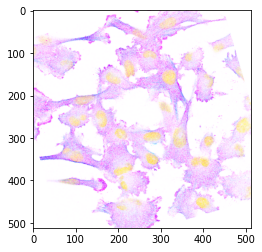

In [14]:
show_sample(*train_ds[1541])

### DataLoaders

In [15]:
batch_size = 50

In [16]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [17]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

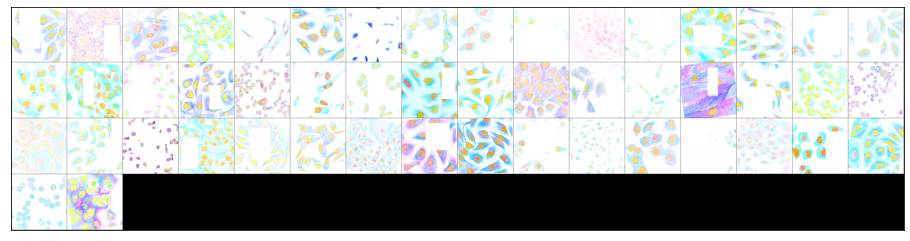

In [18]:
show_batch(train_dl, invert=True)

## Model - Transfer Learning

In [19]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [20]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

[Learn about ResNets.](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [21]:
resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
model = to_device(ProteinResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [28]:
torch.cuda.empty_cache()
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.7503215670585632, 'val_score': 0.24933762848377228}]

First, freeze the ResNet layers and train some epochs. This only trains the final layer to start classifying the images.

In [29]:
model.freeze()

In [30]:
parameters = [(10, 0.002),
    (4, 0.001),
    (4, 0.0005),
    (4, 0.0001),
]
parameters = [(10, 0.002),
]

# n
# first of all do serial wise, not all in same time and then do the test dataset
#increase the epochs of 0.002 to around 12 and see

#best performer
#10, 0.002 and 2, 0.001 achieved                    0.07637 val acc
#10, 0.002 and 4, 0.001 and 3, 0.0005               0.07782 val acc
#10, 0.002 and 4, 0.001 and 3, 0.0005 and 1, 0.0001 0.07913 val acc
#10, 0.002 and 4, 0.001 and 3, 0.0005 and 1, 0.0001 0.07917 val acc loss 0.1662
# after normalising the data
#  , 0.002                                          0.07919 val acc loss 0.1705

# 5, 0.002

In [31]:
opt_func = torch.optim.Adam
for epochs, learning_rate in parameters:
    print("Training for", epochs, 'epoch', "with a learning rate of", learning_rate, "...")
    history += fit(epochs, learning_rate, model, train_dl, val_dl, opt_func)

Training for 10 epoch with a learning rate of 0.002 ...



Epoch [0], train_loss: 0.3311, val_loss: 0.3028, val_score: 0.4787



Epoch [1], train_loss: 0.2830, val_loss: 0.2606, val_score: 0.5594



Epoch [2], train_loss: 0.2542, val_loss: 0.2713, val_score: 0.5585



Epoch [3], train_loss: 0.2357, val_loss: 0.2606, val_score: 0.6421



Epoch [4], train_loss: 0.2299, val_loss: 0.2086, val_score: 0.6945



Epoch [5], train_loss: 0.2139, val_loss: 0.2115, val_score: 0.6968



Epoch [6], train_loss: 0.2075, val_loss: 0.2353, val_score: 0.6612



Epoch [7], train_loss: 0.2007, val_loss: 0.2063, val_score: 0.7058



Epoch [8], train_loss: 0.1969, val_loss: 0.1898, val_score: 0.7447



Epoch [9], train_loss: 0.1934, val_loss: 0.1961, val_score: 0.7222


Now, unfreeze and train some more.

In [64]:
model.unfreeze()

In [46]:
parameters = [(10, 0.002),
    (4, 0.001),
    (4, 0.0005),
    (4, 0.0001),
]
#the unfreezing and training is of no benefit so far
#i think this layer should be finely tuned so low learning rate
# 10, 0.002 doesnt lead to any improvement, 0.001 should be good,


In [65]:
%%time
opt_func = torch.optim.Adam
for epochs, learning_rate in parameters:
    print("Training for", epochs, 'epoch', "with a learning rate of", learning_rate, "...")
    history += fit(epochs, learning_rate, model, train_dl, val_dl, opt_func)


Training for 2 epoch with a learning rate of 5e-05 ...



Epoch [0], train_loss: 0.1179, val_loss: 0.1690, val_score: 0.7987



Epoch [1], train_loss: 0.1178, val_loss: 0.1707, val_score: 0.8025
CPU times: user 2min 51s, sys: 2min 6s, total: 4min 57s
Wall time: 9min 51s


In [ ]:
train_time='22:00'

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

## Making predictions and submission

In [46]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [47]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [48]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.1977e-03, 1.1523e-03, 3.3870e-03, 7.5910e-04, 9.9272e-01, 1.2224e-03,
        9.1734e-01, 2.6768e-02, 6.7069e-04, 1.2369e-06], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


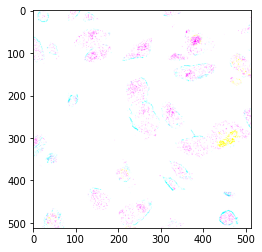

In [49]:
predict_single(test_dataset[100][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  tensor([6.1522e-01, 3.4927e-04, 7.7275e-04, 6.5389e-01, 3.1079e-02, 2.0046e-04,
        1.0070e-02, 1.5519e-04, 3.6259e-03, 1.0209e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0) Golgi apparatus(3)


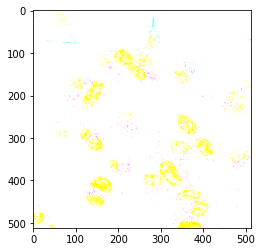

In [50]:
predict_single(test_dataset[74][0])

In [51]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [52]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [53]:
test_preds = predict_dl(test_dl, model)

In [54]:
latest =history[-1]
latest['val_loss'], latest['val_score']

(0.17054449021816254, 0.7918778657913208)

In [55]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

,Image,Label
5168,27233,7
6336,26023,3 4
5962,2884,3 4 6
6513,27639,9
5100,12658,8
5971,24299,2 6
4931,23286,4 6
1,15322,4
5122,6801,4
6285,7597,3 4


In [56]:
sub_fname = 'submissionforkaggle7919_1705_freeze.csv'
#0.07919 val acc loss 0.1705

In [57]:
submission_df.to_csv(sub_fname, index=False)

## Save and Commit

In [ ]:
weights_fname = 'protein-resnet.pth'
torch.save(model.state_dict(), weights_fname)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=2*epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_score=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
project_name='protein-advanced'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])